In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(set(''.join(words)))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
device = torch.device('cpu')
block_size = 3
# words = words[:10]
def build_dataset(words):
    X , Y = [] , []
    for word in words:
        context = [0] * block_size
        for ch in word+'.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            # print(context,'----------->',idx)
            context = context[1:]+[idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X.to(device),Y.to(device)

import random

random.seed(42)
random.shuffle(words)
n1 = int( 0.8 * len(words))
n2 = int( 0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])
Xval , Yval = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [6]:
n_embd = 10
n_hidden = 200

g = torch.Generator(device=device).manual_seed(2 ** 31 -1)

C = torch.randn((vocab_size,n_embd),                generator=g , device = device)
w1 = torch.randn((n_embd * block_size,n_hidden),    generator=g , device = device) * (5 / 3) / (n_embd * block_size) ** 0.5
b1 = torch.randn((n_hidden),                        generator=g , device = device) * 0.1
w2 = torch.randn((n_hidden,vocab_size),             generator=g , device = device) * 0.01
b2 = torch.randn(vocab_size,                        generator=g , device = device) * 0

bgain = torch.ones((1,n_hidden),device = device)
bbias = torch.zeros((1,n_hidden),device = device)

bnmean_running = torch.ones((1,n_hidden), device = device)
bnstd_running = torch.zeros((1,n_hidden) , device = device)

parameters = [C,w1,b1,w2,b2,bgain,bbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12297


In [7]:
max_steps = 200000
batch_size = 32

lossi = []

for i in range(max_steps+1):
    #minibatch construct

    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g,device= device)
    Xb , Yb = Xtr[ix] , Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ w1 + b1
    
    bnmeani = hpreact.mean(0,keepdim = True)
    bnstdi = hpreact.std(0,keepdim = True)

    hpreact = bgain* (hpreact -  bnmeani) / bnstdi + bbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Yb)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnmean_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps : 7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0 /  200000: 3.3010
  10000 /  200000: 2.6008
  20000 /  200000: 1.9211
  30000 /  200000: 2.3886
  40000 /  200000: 2.1611
  50000 /  200000: 2.6241
  60000 /  200000: 2.3536
  70000 /  200000: 2.2120
  80000 /  200000: 2.1534
  90000 /  200000: 2.0049
 100000 /  200000: 2.2355
 110000 /  200000: 1.7124
 120000 /  200000: 2.0548
 130000 /  200000: 2.1423
 140000 /  200000: 2.0597
 150000 /  200000: 2.0634
 160000 /  200000: 1.6968
 170000 /  200000: 2.3551
 180000 /  200000: 1.9362
 190000 /  200000: 2.3045
 200000 /  200000: 1.9798


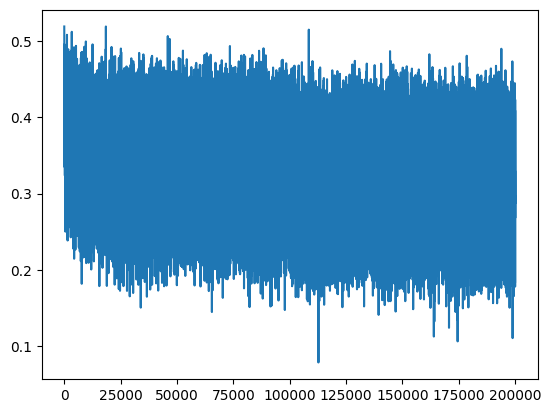

In [8]:
plt.plot(lossi)

In [9]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)

    hpreact = embcat@ w1 #+ b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [10]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : {Xtr,Ytr},
        'val' : {Xval,Yval},
        'test' : {Xte,Yte}
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ w1 + b1
    hpreact = bgain * (hpreact -  bnmean) / bnstd + bbias
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.0693318843841553
val 2.1139562129974365


In [11]:
g = torch.Generator(device=device).manual_seed(2 ** 31)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh((emb.view(1,-1)) @ w1 +b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits,dim = 1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

diz.
legsufntam.
dre.
dfis.
hskey.
jusmingten.
zursum.
xzib.
lynn.
zrynn.
nyniayidalzugrydn.
ydyn.
crichannathi.
devrylodil.
porgiydithaaleeffir.
jumiribsub.
daegulia.
junenntharlis.
quisracenglaelynn.
drynn.


In [12]:
class Linear:
    def __init__(self,fan_in,fan_out,bias = True):
        self.weight = torch.randn((fan_in,fan_out), generator=g, device=device) / fan_in ** 0.5
        self.bias = torch.randn((fan_out,), generator=g, device=device) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [31]:
class BatchNorm1d:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters
        self.beta = torch.ones(dim, device=device)
        self.gamma = torch.zeros(dim, device=device)

        #buffers

        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self,x):
        if self.training:
            xmean = x.mean(0,keepdim = True)
            xvar = x.var(0,keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.beta * xhat + self.gamma
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + (self.momentum * xmean)
                self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)
        return self.out
    def parameters(self):
        return [self.beta ,self.gamma]
    

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [32]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


47024


In [33]:
# same optimization as last time
device = torch.device('cpu')
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g,device = device)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 4.0467
  10000/ 200000: 2.2407
  20000/ 200000: 2.2093
  30000/ 200000: 2.4215
  40000/ 200000: 2.2971
  50000/ 200000: 2.8938
  60000/ 200000: 2.2079
  70000/ 200000: 2.4271
  80000/ 200000: 1.9235
  90000/ 200000: 2.2859
 100000/ 200000: 2.2433
 110000/ 200000: 1.8185
 120000/ 200000: 2.2336
 130000/ 200000: 2.2697
 140000/ 200000: 1.6824
 150000/ 200000: 2.2627
 160000/ 200000: 2.1859
 170000/ 200000: 1.9471
 180000/ 200000: 1.7834
 190000/ 200000: 1.7899


In [34]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr, Ytr),
        'val':(Xval,Yval),
        'test':(Xte,Yte),
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,y)
    print(split,loss.item())

    for layer in layers:
        layer.training = False
    split_loss('train')
    split_loss('val')

In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

C:\Users\mugil\AppData\Local\Temp\ipykernel_24464\1041823147.py:18: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  xvar = x.var(0,keepdim = True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0